<h1>The Most Environmentally Friendly Neighborhood in Pittsburgh</h1>

<h1>Introduction</h1>

<p>Each neighborhood in Pittsburgh has its own unique appeal but most people can agree that the quality of the environment is a major contributing factor when considering a place to live. Thus, we decided to look at environmental data for each neighborhood in order to determine which one is the <strong>"best"</strong> in Pittsburgh. As sub-metrics we chose to look at number of trees per neighborhood, illegal dump site locations, and fire incidents data.</p>

<h4>Map of Pittsburgh Neighborhoods from <a href="https://www.visitpittsburgh.com/neighborhoods/">VisitPittsburgh</a></h4>
<img src="http://s3.amazonaws.com/visit-pittsburgh/CMS/2020-Neighborhood-Map2.jpg" width="80%">

<!-- Neighborhood Trees Data analyzed by: Brian Hutton -->
<hr>
<h2><u>Neighborhood Trees</u></h2>
<p>When considering what makes a neighborhood great, you may not initially consider the number of trees in the neighborhood as a deciding factor. But, the trees around you improve your quality of life in many ways.</p>

<h4>Environmental and Economic Benefits that Trees Provide:</h4>
<ul>
    <li>trees provide breathable oxygen and remove hazardous pollutants from the air</li>
    <li>trees absorb carbon dioxide, the primary greenhouse gas linked to global warming</li>
    <li>trees reduce the amount of storm water runoff which in turn reduces pollution in local bodies of water</li>
    <li>trees provide habitats for local wildlife</li>
    <li>appropriately placed trees provide shade and reduce cooling costs for homes</li>
</ul>
<p>Now that we have an idea of why trees are beneficial, let's look at some data.</p>

<h4>Data Sources</h4>
<p>The data I used came from the <a href="http://www.wprdc.org/">Western Pennsylvania Regional Data Center</a>. The Western Pennsylvania Regional Data Center hosts many datasets gathered by public sector agencies, academic institutions, and non-profit organizations. The data set I used was the <a href="https://data.wprdc.org/dataset/city-trees/resource/1515a93c-73e3-4425-9b35-1cd11b2196da">City of Pittsburgh Trees</a> data set, which looks at trees cared for and managed by the City of Pittsburgh Department of Public Works Forestry Division. The quantifiable tree benefits were calculated using the <a href="http://www.treebenefits.com/calculator/webservicedescription.cfm">National Tree Benefit Calculator Web Service
</a>. The benefits featured in this dataset are quantified on an annual basis and presented in terms of resource units and
dollars. Some of the quantifiable benefits featured in this dataset are:
<ul>
    <li>pounds of carbon dioxide sequestered</li>
    <li>gallons of stormwater absorbed</li>
    <li>pounds of sulfur dioxide, nitrogen dioxide, and ozone filtered</li>
</ul>
Lastly, there is a column in this dataset that is a summary of the dollar value of a given tree. The trees dollar value is determined by its contributions to energy reduction, stormwater absorption, and air pollution reduction.
</p>

<h4><u>Neighborhood with Most Trees</u></h4>
<p>First, let's look at which neighborhood has the most trees.</p>

In [1]:
# Pittsburgh Trees data analyzed by: Brian Hutton
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import seaborn as sns
from IPython.core.display import display, HTML
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Read in tree data file from WPRDC
trees_dataset = pd.read_csv("pittsburgh_trees.csv", low_memory=False)
trees_dataset = trees_dataset.reset_index()

# Get list of neighborhoods in dataset
neighborhood_names = trees_dataset['neighborhood'].unique()

# Figure out the counts for number of trees per neighborhood
trees_per_neighborhood = trees_dataset['neighborhood'].value_counts().to_dict()

# create new column in dataframe and for each row in dataframe add tree count for that neighborhood
trees_dataset['counts'] = 0
for index, row in trees_dataset.iterrows():
    trees_dataset.at[index, 'counts'] = trees_per_neighborhood.get(row['neighborhood'])

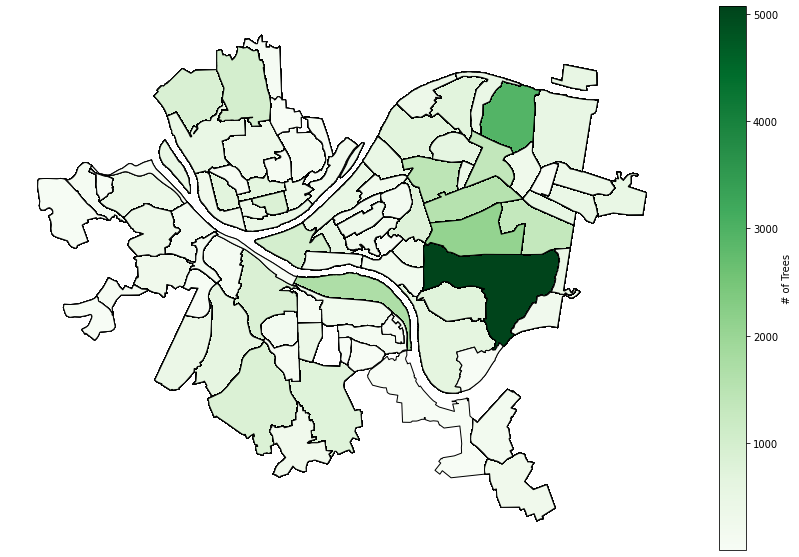

In [2]:
# Brian: printing map of tree counts

# read in the shapefile
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")

# couldn't figure out how to set title so just writing to markdown
display(HTML("<h3>Trees Per Neighborhood</h3>"))

# map plotting with geopandas
# found colormaps here: https://matplotlib.org/2.0.2/users/colormaps.html
trees_map = neighborhoods.merge(trees_dataset, how='left', left_on='hood', right_on='neighborhood')
trees_plot = trees_map.plot(column='counts', edgecolor="black", cmap='Greens', legend=True, legend_kwds={'label': "# of Trees"}, figsize=(15, 10))
trees_plot.set_axis_off();

In [3]:
# Brian: convert trees_per_neighborhood dictionary to dataframe
trees_per_neighborhood_df = pd.DataFrame(trees_per_neighborhood.items(), columns=['neighborhood', 'counts'])
trees_per_neighborhood_df.head(10)

,neighborhood,counts
0,Squirrel Hill South,5073
1,Highland Park,2941
2,Squirrel Hill North,2083
3,South Side Flats,1693
4,Shadyside,1558
5,Bloomfield,1436
6,East Liberty,1366
7,Point Breeze,1316
8,Perry North,1007
9,Central Business District,1002


In [4]:
#Brian: Using dictionaries to keep track of pounds of carbon dioxide per neighborhood and how many entries for each neighborhood
carbon_per_neighborhood = {}
carbon_count_per_neighborhood = {}

for n in neighborhood_names:
    carbon_per_neighborhood[n] = 0
    carbon_count_per_neighborhood[n] = 0

for index, row in trees_dataset.iterrows():
    # if value at row is not 'nan'
    if not(math.isnan(row['co2_benefits_sequestered_lbs'])):
        carbon_per_neighborhood[row['neighborhood']] += float(row['co2_benefits_sequestered_lbs'])
        carbon_count_per_neighborhood[row['neighborhood']] += 1

# computing average for each neighborhood
for n in neighborhood_names:
    # don't want to divide by zero
    if carbon_count_per_neighborhood[n] != 0:
        carbon_per_neighborhood[n] /= carbon_count_per_neighborhood[n]
        
carbon_dict = {
    'Neighborhood': [],
    'Avg Pounds CO2 Seq': []
}

for key in carbon_per_neighborhood:
    carbon_dict['Neighborhood'].append(key)
    carbon_dict['Avg Pounds CO2 Seq'].append(round(carbon_per_neighborhood[key],2))
    
# convert dictionary to dataframe
carbon_per_neighborhood_df = pd.DataFrame.from_dict(carbon_dict)
carbon_per_neighborhood_df.head(20)
carbon_per_neighborhood_df.nlargest(n=10, columns=['Avg Pounds CO2 Seq'])

,Neighborhood,Avg Pounds CO2 Seq
77,Fairywood,330.14
42,Squirrel Hill North,239.37
5,Stanton Heights,236.30
19,Allegheny Center,235.97
73,Swisshelm Park,222.60
4,Highland Park,205.65
43,Point Breeze,205.51
48,New Homestead,201.74
55,Allegheny West,196.85
7,Chartiers City,195.62


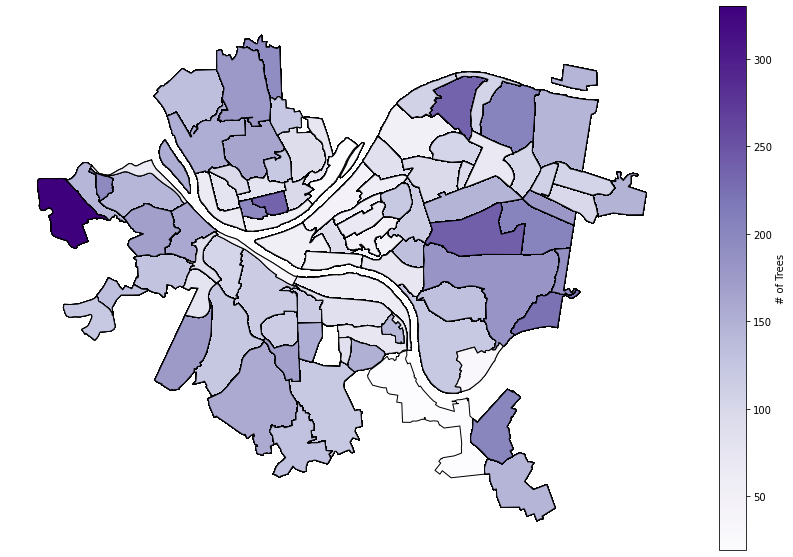

In [5]:
display(HTML("<h3>Average Pounds of CO<sub>2</sub> Sequestered by Neighborhood</h3>"))

# add average pounds of c02 sequestered to original dataframe for each neighborhood
trees_dataset['avg co2 seq per neighborhood'] = 0.0
for index, row in trees_dataset.iterrows():
    trees_dataset.at[index, 'avg co2 seq per neighborhood'] = carbon_per_neighborhood.get(row['neighborhood'])
    
carbon_map = neighborhoods.merge(trees_dataset, how='left', left_on='hood', right_on='neighborhood')
carbon_plot = carbon_map.plot(column='avg co2 seq per neighborhood', edgecolor="black", cmap='Purples', legend=True, legend_kwds={'label': "# of Trees"}, figsize=(15, 10))
carbon_plot.set_axis_off();

<h3>Tree Data Conclusions</h3>
<p>
We can see that the trend seems to be, the neighborhood with the most trees tends to have the greatest impact on the reduction of CO<sub>2</sub>. Squirrel Hill is the neighborhood with the most trees and is second among the top ten neighborhoods whose trees absorb the most carbon dioxide. Since Squirrel Hill is one of the largest neighborhoods in Pittsburgh and it has some fairly large parks (Frick Park and Schenley Park) it makes sense that it is the neighborhood with the most trees. Since Squirrel Hill has the most trees in Pittsburgh and these trees contribute significantly to the reduction of CO<sub>2</sub> it's fair to say that Squirrel Hill is the best neighborhood in Pittsburgh when considering the best to be the most environmentally friendly.
</p>

<p>
When exploring this data, I wanted to find out how many trees are in the neighborhood in which I grew up, Knoxville.
</p>

In [6]:
trees_in_knox = trees_per_neighborhood['Knoxville']
co2_knox = round(carbon_per_neighborhood['Knoxville'],2)
display(HTML("<p>Knoxville has {0} trees which absorb {1} pounds of carbon dioxide.</p>".format(trees_in_knox, co2_knox)))

<p>Since Knoxville does not have very many large parks and itself is not a large neighborhood, it's not very surprising that it is not among the top ten neighborhoods with the most trees.</p>

<p>
By exploring this dataset I feel that I have gained insight as far as how trees are distributed throughout the city of Pittsburgh.
</p>

<img src="https://i.kym-cdn.com/photos/images/original/001/623/587/c91.png" width="50%">

<hr>

<h2><u>Illegal Dump Sites</u></h2>

<p>When trying to figure out what factors to rely on for coming up with the answer to makes an optimal environment to live in, illegal dump sites might not be the first thing that comes to your mind. But trust me, it is of great importance.<p>

<h4>Effects of Illegal Dumping on the Environment:</h4>
<ul>
    <li>Soil and Water become contaminated due to a lack of monitoring.</li>
    <li>Wildlife is disrupted as they are the first to sense the shift in environment.</li>
    <li>Risk of Natural disasters.</li>
</ul>

<h4>Effects of Illegal Dumping in our Community:</h4>
<ul>
    <li>Possibility of health issues increase.</li>
    <li>Property values decrease.</li>
    <li>Citizens can take on clean up costs.</li>
</ul>
<p>Now that we have an idea as to how influential illegal dumping can be when deciding the optimality of the environment, let's take a look at some data regarding the dumping sites.<p>
    
<h4><a href="https://data.wprdc.org/dataset/allegheny-county-illegal-dump-sites/resource/ee834d8d-ae71-4b3b-b02b-312ba321ff17">Illegal Dump Data Source</a></h4>
<p> The data set I used for Illegal Dump Sites Data came from the <a href="http://www.wprdc.org/">Western Pennsylvania Regional Data Center</a>. The Western Pennsylvania Regional Data Center hosts many datasets gathered by public sector agencies, academic institutions, and non-profit organizations. Specifically, this <a href="https://data.wprdc.org/dataset/allegheny-county-illegal-dump-sites/resource/ee834d8d-ae71-4b3b-b02b-312ba321ff17?view_id=1988368f-ec43-430c-9478-bd31164c1326">data set</a> features information on illegal dump sites, their type of trash, and the estimate tons of trash at each site which covers 79 neighborhoods.</p>

In [7]:
#Aziz: Reading the illegal dumpsites file
dump_data = pd.read_csv("illegaldumpsites.csv")
dump_data['estimated_tons'] = pd.to_numeric(dump_data['estimated_tons'])
dump_data = dump_data.reset_index()
dump_data['counts'] = 0

#copy dataframe
filter = ["Pittsburgh"]
dump2 = dump_data[dump_data.City.isin(filter)]
dump2 = dump2.reset_index()


#lets get the names of the neighborhood
neighborhood_names = dump2['Neighborhood'].unique()

#count of Illegal dump sites
sites_per_neighborhood = dump2['Neighborhood'].value_counts().to_dict()

#create new column in dataframe and for each row in dataframe add tree count for that neighborhood
for index, row in dump2.iterrows():
    dump2.at[index, 'counts'] = sites_per_neighborhood.get(row['Neighborhood'])


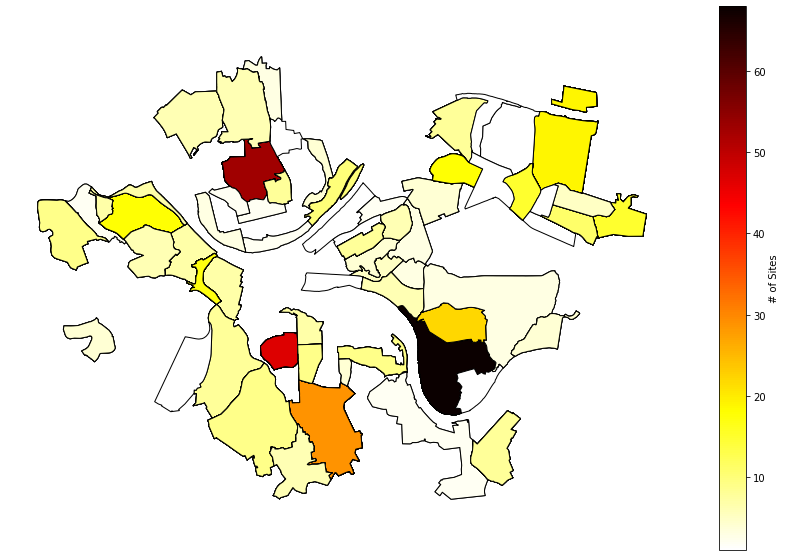

In [8]:
# read in the shapefile
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")

display(HTML("<h3>Sites Per Neighborhood</h3>"))

#map plotting
sites_map = neighborhoods.merge(dump2, how='left', left_on='hood', right_on='Neighborhood')
sites_plot = sites_map.plot(column='counts', edgecolor="black", cmap='hot_r', legend=True, legend_kwds={'label': "# of Sites"}, figsize=(15, 10))
sites_plot.set_axis_off();

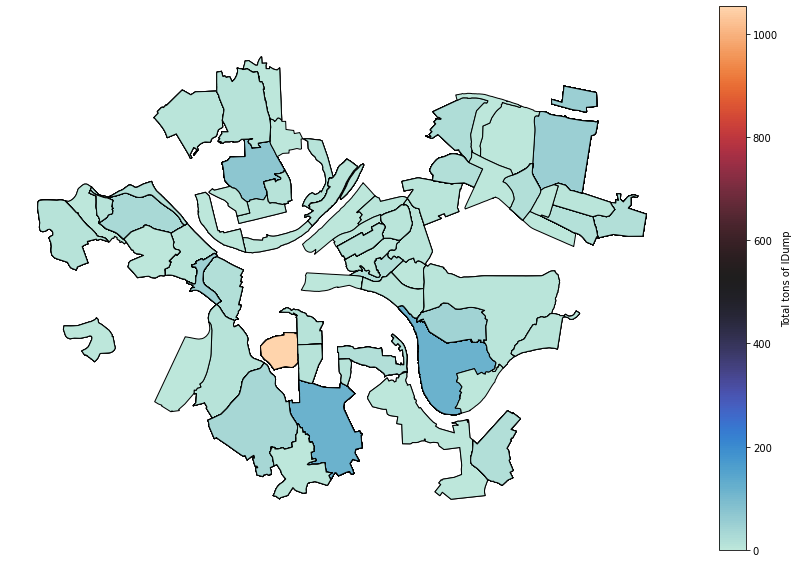

In [9]:
#Tons of weight per neighbourhood
dump3 = dump2.groupby(["Neighborhood"]).estimated_tons.sum().reset_index()
dump3.columns = ['Neighborhood', 'total_tons']

#adding total tons of illegaly displaced dump to original dataframe
dump4 = pd.merge(dump2, dump3, how='left', on='Neighborhood')
dump4.head(10)
display(HTML("<h3>Total Tons of Illegal dump by Neighborhood</h3>"))

#map plotting
total_map = neighborhoods.merge(dump4, how='left', left_on='hood', right_on='Neighborhood')
total_plot = total_map.plot(column='total_tons', edgecolor="black", cmap='icefire', legend=True, legend_kwds={'label': "Total tons of IDump"}, figsize=(15, 10))
total_plot.set_axis_off();

In [10]:
#Max and min illegally displaced waste
print('The neighborhood with the least illegaly displaced waste dump:')
print(dump3.min(), '\n')
print('The neighborhood with the most illegaly displaced waste dump:')
print(dump3.max())

The neighborhood with the least illegaly displaced waste dump:
Neighborhood    Allentown
total_tons            0.0
dtype: object 

The neighborhood with the most illegaly displaced waste dump:
Neighborhood    Windgap
total_tons       1053.0
dtype: object


<hr>

<h2>Fire Incidents</h2>
<p>The data set I used for Fire Incidents Data came from the Western Pennsylvania Regional Data Center. This data set features information on Fire Incidents, their types of fires, and the amount of fires covering a total of 91 neighborhoods.</p>

<h3>Types of Fires</h3>
<ul>
    <li>Building Fires</li>
    <li>Vehicle Fires</li>
    <li>Outside Rubbish Fires</li>
    <li>Trash Waste Fires</li>
    <li>Cooking Fires</li>
    <li>Other</li>
</ul>

<h3>Effect of Fires on the Environment:</h3>
<ul>
    <li>Possibility of health issues increase.</li>
    <li>Possibility of property damage</li>
    <li>Expensive costs to maintain.</li>
    <li>Posibility of wildlife getting disrupted.</li>
    <li>Posibility of soil damage.</li>
</ul>

In [11]:
# Fire Incidents Dataset Analysis By: Eric Lim
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import seaborn as sns
from IPython.core.display import display, HTML
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Read File
fire_incidents_dataset = pd.read_csv("fireincidents.csv")
fire_incidents_dataset = fire_incidents_dataset.reset_index()

# Gets List of Neighborhoods
neighborhood_list = fire_incidents_dataset['neighborhood'].unique()

# Gets Frequency of Fire Incidents per Neighborhood
fires_per_neighborhood = fire_incidents_dataset['neighborhood'].value_counts().to_dict()

# Create New Column in Dataframe and For Each Row in Dataframe Add Fire Count For That Neighborhood
fire_incidents_dataset['counts'] = 0
for index, row in fire_incidents_dataset.iterrows():
    fire_incidents_dataset.at[index, 'counts'] = fires_per_neighborhood.get(row['neighborhood'])

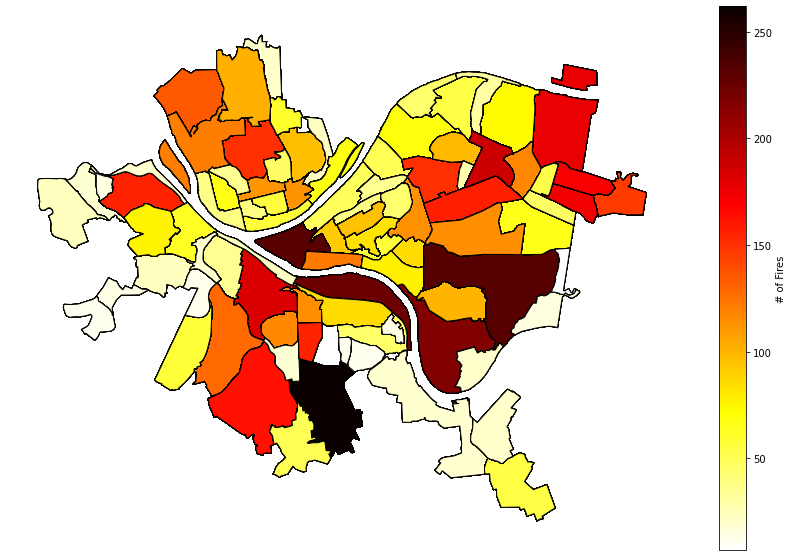

In [12]:
# Printing Map of Fire Incidents Counts

# Read in The Shapefile
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")

# Title of Map
display(HTML("<h3>Fires Per Neighborhood</h3>"))

# Map Plotting
fires_map = neighborhoods.merge(fire_incidents_dataset, how='left', left_on='hood', right_on='neighborhood')
fires_plot = fires_map.plot(column='counts', edgecolor="black", cmap='hot_r', legend=True, legend_kwds={'label': "# of Fires"}, figsize=(15, 10))
fires_plot.set_axis_off();

In [13]:
# Title of Dataframe
display(HTML("<h3>Top 10 Neighborhoods</h3>"))

# Convert Fires Dictionary to a Dataframe
fires_per_neighborhood_df = pd.DataFrame(fires_per_neighborhood.items(), columns=['neighborhood', 'counts'])
fires_per_neighborhood_df.tail(11)

,neighborhood,counts
80,Windgap,18
81,Swisshelm Park,15
82,Chartiers City,14
83,Arlington Heights,13
84,Oakwood,13
85,Ridgemont,12
86,St. Clair,11
87,East Carnegie,11
88,Mt. Oliver,11
89,Regent Square,7


In [14]:
# Title of Dataframe
display(HTML("<h3>Bottom 10 Neighborhoods</h3>"))

# Convert Fires Dictionary to a Dataframe
fires_per_neighborhood_df = pd.DataFrame(fires_per_neighborhood.items(), columns=['neighborhood', 'counts'])
fires_per_neighborhood_df.head(11)

,neighborhood,counts
0,Carrick,262
1,Squirrel Hill South,233
2,Central Business District,232
3,South Side Flats,225
4,Hazelwood,217
5,East Liberty,188
6,Mount Washington,183
7,Lincoln-Lemington-Belmar,177
8,Homewood South,174
9,Homewood North,171


<h3>Fire Incidents Data Conclusion</h3>
<p>The neighborhoods with the most fires tends to have a greater area. Mount Oliver is the neighborhood with the fewest fire incidents, followed by Regent Square. On the other hand, Carrick is the neighborhood with the most fire incidents followed by Squirrel Hill. It makes sense that Carrick and Squirrel Hill has the most fires because they are fairly large neighborhoods compared to neighborhoods like Mount Oliver or Regent Square.</p>

<hr>
<h3>Overall Conclusions</h3>
<p>Upon looking at the neighborhoods with the most trees, least tons of waste dumped, and fewest fire incidents we determined that <b>Ridgemont</b> was the best neighborhood. Although Ridgemont does not have a lot of trees, it was among the top ten in fewest fire incidents and fewest tons of waste dumped.</p>

<h3>Resources</h3>
<!-- everyone add the resources they used here -->
<ul>
    <li>Neighborhood Trees Dataset from: <a href="https://data.wprdc.org/dataset/city-trees/resource/1515a93c-73e3-4425-9b35-1cd11b2196da">WPRDC</a></li>
    <li>Tree Benefits Information from: <a href="http://www.treebenefits.com/calculator/webservicedescription.cfm">Tree Benefits Calculator site</a></li>
    <li>Illegal Dump Site Dataset from: <a href="https://data.wprdc.org/dataset/allegheny-county-illegal-dump-sitesinner_span=True">WPRDC</a></li>
    <li>Illegal Dumping effects information from: <a href="https://www.dumpsters.com/blog/consequences-of-illegal-dumping">Illegal Dumping Harmful impact</a></li>
    <li>Fire Incidents Dataset from: <a href="https://data.wprdc.org/dataset/allegheny-county-illegal-dump-sitesinner_span=True">WPRDC</a></li>
    <li>Fire Disadvantage effects from: <a href="http://www.pacificbio.org/initiatives/fire/fire_ecology.html#:~:text=Disadvantages%3A,intense%20fire%2C%20erosion%20can%20occur.">Fire Disadvantages</a></li>
</ul>